In [1]:
import os
from PIL import Image
import itertools
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')


In [3]:
train_data_path = 'chest_xray/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    if fold!='.DS_Store':
        foldpath = os.path.join(train_data_path, fold)
        filelist = os.listdir(foldpath)
        
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

df = pd.concat([FSeries, LSeries], axis=1)
df

,filepaths,label
0,chest_xray/chest_xray/train\NORMAL\.DS_Store,NORMAL
1,chest_xray/chest_xray/train\NORMAL\IM-0115-000...,NORMAL
2,chest_xray/chest_xray/train\NORMAL\IM-0117-000...,NORMAL
3,chest_xray/chest_xray/train\NORMAL\IM-0119-000...,NORMAL
4,chest_xray/chest_xray/train\NORMAL\IM-0122-000...,NORMAL
...,...,...
5213,chest_xray/chest_xray/train\PNEUMONIA\person99...,PNEUMONIA
5214,chest_xray/chest_xray/train\PNEUMONIA\person9_...,PNEUMONIA
5215,chest_xray/chest_xray/train\PNEUMONIA\person9_...,PNEUMONIA
5216,chest_xray/chest_xray/train\PNEUMONIA\person9_...,PNEUMONIA


In [5]:
valid_data_dir = 'chest_xray/chest_xray/val'
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)
#print(folds)
for fold in folds:
    if fold!='.DS_Store':
        foldpath = os.path.join(valid_data_dir, fold)
        filelist = os.listdir(foldpath)
        
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

valid = pd.concat([FSeries, LSeries], axis=1)
valid

,filepaths,label
0,chest_xray/chest_xray/val\NORMAL\.DS_Store,NORMAL
1,chest_xray/chest_xray/val\NORMAL\NORMAL2-IM-14...,NORMAL
2,chest_xray/chest_xray/val\NORMAL\NORMAL2-IM-14...,NORMAL
3,chest_xray/chest_xray/val\NORMAL\NORMAL2-IM-14...,NORMAL
4,chest_xray/chest_xray/val\NORMAL\NORMAL2-IM-14...,NORMAL
5,chest_xray/chest_xray/val\NORMAL\NORMAL2-IM-14...,NORMAL
6,chest_xray/chest_xray/val\NORMAL\NORMAL2-IM-14...,NORMAL
7,chest_xray/chest_xray/val\NORMAL\NORMAL2-IM-14...,NORMAL
8,chest_xray/chest_xray/val\NORMAL\NORMAL2-IM-14...,NORMAL
9,chest_xray/chest_xray/val\PNEUMONIA\.DS_Store,PNEUMONIA


In [7]:
test_data_dir = 'chest_xray/chest_xray/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for fold in folds:
    if fold!='.DS_Store':
        foldpath = os.path.join(test_data_dir, fold)
        filelist = os.listdir(foldpath)
        
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')

test = pd.concat([FSeries, LSeries], axis=1)
test

,filepaths,label
0,chest_xray/chest_xray/test\NORMAL\IM-0001-0001...,NORMAL
1,chest_xray/chest_xray/test\NORMAL\IM-0003-0001...,NORMAL
2,chest_xray/chest_xray/test\NORMAL\IM-0005-0001...,NORMAL
3,chest_xray/chest_xray/test\NORMAL\IM-0006-0001...,NORMAL
4,chest_xray/chest_xray/test\NORMAL\IM-0007-0001...,NORMAL
...,...,...
619,chest_xray/chest_xray/test\PNEUMONIA\person96_...,PNEUMONIA
620,chest_xray/chest_xray/test\PNEUMONIA\person96_...,PNEUMONIA
621,chest_xray/chest_xray/test\PNEUMONIA\person97_...,PNEUMONIA
622,chest_xray/chest_xray/test\PNEUMONIA\person99_...,PNEUMONIA


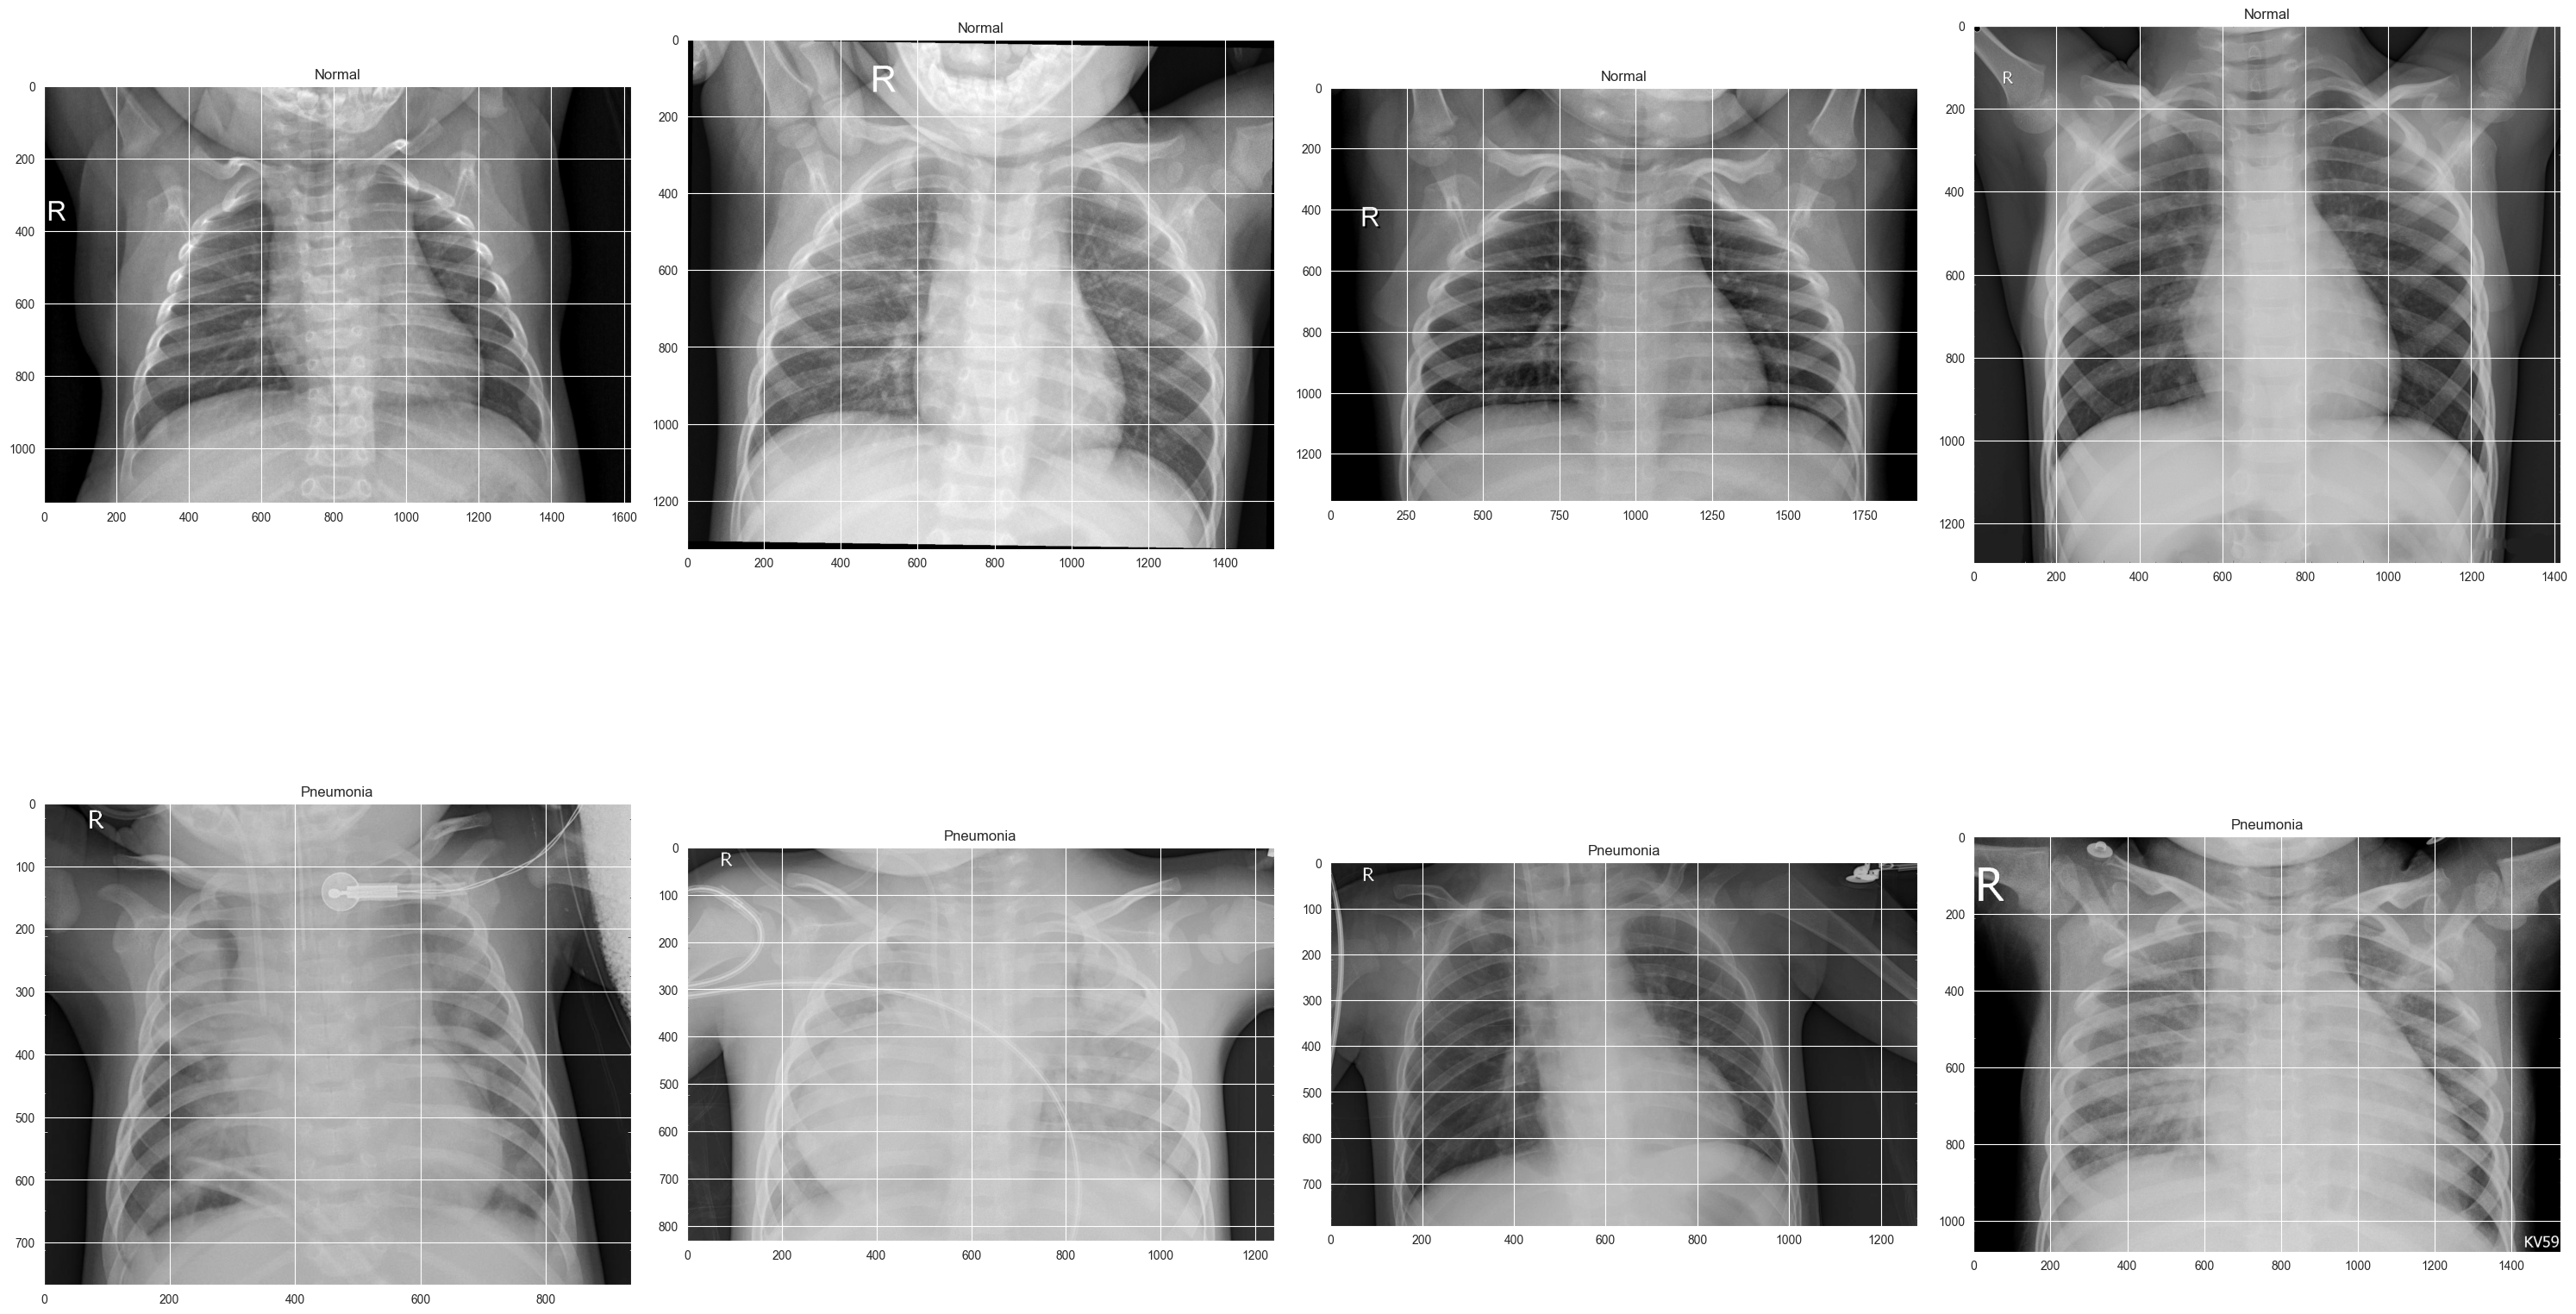

In [9]:
import matplotlib.pyplot as plt
import random

# Preprocessing Train Dataset
train_data_path = 'chest_xray/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    if fold!='.DS_Store':
        foldpath = os.path.join(train_data_path, fold)
        filelist = os.listdir(foldpath)
        
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
        
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')
df = pd.concat([FSeries, LSeries], axis=1)

# Visualize some normal and pneumonia images
plt.figure(figsize=(30, 20))

# Display 4 normal images
plt.subplot(2, 4, 1)
normal_images = df[df['label'] == 'NORMAL']['filepaths'].tolist()
normal_image = Image.open(random.choice(normal_images))
plt.imshow(normal_image, cmap='gray')
plt.title('Normal')

plt.subplot(2, 4, 2)
normal_image = Image.open(random.choice(normal_images))
plt.imshow(normal_image, cmap='gray')
plt.title('Normal')

plt.subplot(2, 4, 3)
normal_image = Image.open(random.choice(normal_images))
plt.imshow(normal_image, cmap='gray')
plt.title('Normal')

plt.subplot(2, 4, 4)
normal_image = Image.open(random.choice(normal_images))
plt.imshow(normal_image, cmap='gray')
plt.title('Normal')

# Display 4 pneumonia images
plt.subplot(2, 4, 5)
pneumonia_images = df[df['label'] == 'PNEUMONIA']['filepaths'].tolist()
pneumonia_image = Image.open(random.choice(pneumonia_images))
plt.imshow(pneumonia_image, cmap='gray')
plt.title('Pneumonia')

plt.subplot(2, 4, 6)
pneumonia_image = Image.open(random.choice(pneumonia_images))
plt.imshow(pneumonia_image, cmap='gray')
plt.title('Pneumonia')

plt.subplot(2, 4, 7)
pneumonia_image = Image.open(random.choice(pneumonia_images))
plt.imshow(pneumonia_image, cmap='gray')
plt.title('Pneumonia')

plt.subplot(2, 4, 8)
pneumonia_image = Image.open(random.choice(pneumonia_images))
plt.imshow(pneumonia_image, cmap='gray')
plt.title('Pneumonia')

plt.tight_layout()
plt.show()

In [11]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=1)

batch_size = 64
img_size = (224, 224)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = val_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


In [17]:
from tensorflow.keras.layers import Conv2D, Multiply, Add, Activation

def attention_block(input_tensor, filters):
    # First convolution layer
    conv1 = Conv2D(filters, (3, 3), padding='same')(input_tensor)
    conv1 = Activation('relu')(conv1)

    # Second convolution layer
    conv2 = Conv2D(filters, (3, 3), padding='same')(conv1)
    conv2 = Activation('relu')(conv2)

    # Attention Mechanism
    attn = Add()([conv1, conv2])
    attn = Activation('relu')(attn)
    attn = Conv2D(1, (1, 1), padding='same')(attn)
    attn = Activation('softmax')(attn)

    # Multiply the input (features) with the attention map
    output_tensor = Multiply()([input_tensor, attn])

    return output_tensor

# Define the model
input_tensor = keras.Input(shape=(224, 224, 3))
x = attention_block(input_tensor, 64)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = attention_block(x, 128)

# another layer
# x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2))(x)
# x = attention_block(x, 256)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)  # Added dense layer
x = Dense(64, activation='relu')(x)  # Added another dense layer
output_tensor = Dense(2, activation='softmax')(x)

model = keras.Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_gen, validation_data=valid_gen, verbose = 1, epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(test_gen)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4399s 66s/step - accuracy: 0.7744 - loss: 1501.0225 - val_accuracy: 0.9253 - val_loss: 5.6597
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 5055s 77s/step - accuracy: 0.9495 - loss: 1.8829 - val_accuracy: 0.9100 - val_loss: 1.5719
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 26254s 403s/step - accuracy: 0.9810 - loss: 0.3618 - val_accuracy: 0.9406 - val_loss: 1.0696
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 17538s 269s/step - accuracy: 0.9854 - loss: 0.2348 - val_accuracy: 0.9444 - val_loss: 1.0600
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 5389s 82s/step - accuracy: 0.9862 - loss: 0.1269 - val_accuracy: 0.9291 - val_loss: 1.1422
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3521s 54s/step - accuracy: 0.9950 - loss: 0.0632 - val_accuracy: 0.9425 - val_loss: 1.1322
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 19161s 294s/step - accuracy: 0.9966 - loss: 0.0372 - val_accuracy: 0.9483 - val_loss: 1.0110
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 4464s 68s/step - accuracy: 0.9991 - loss: 0.0155 -

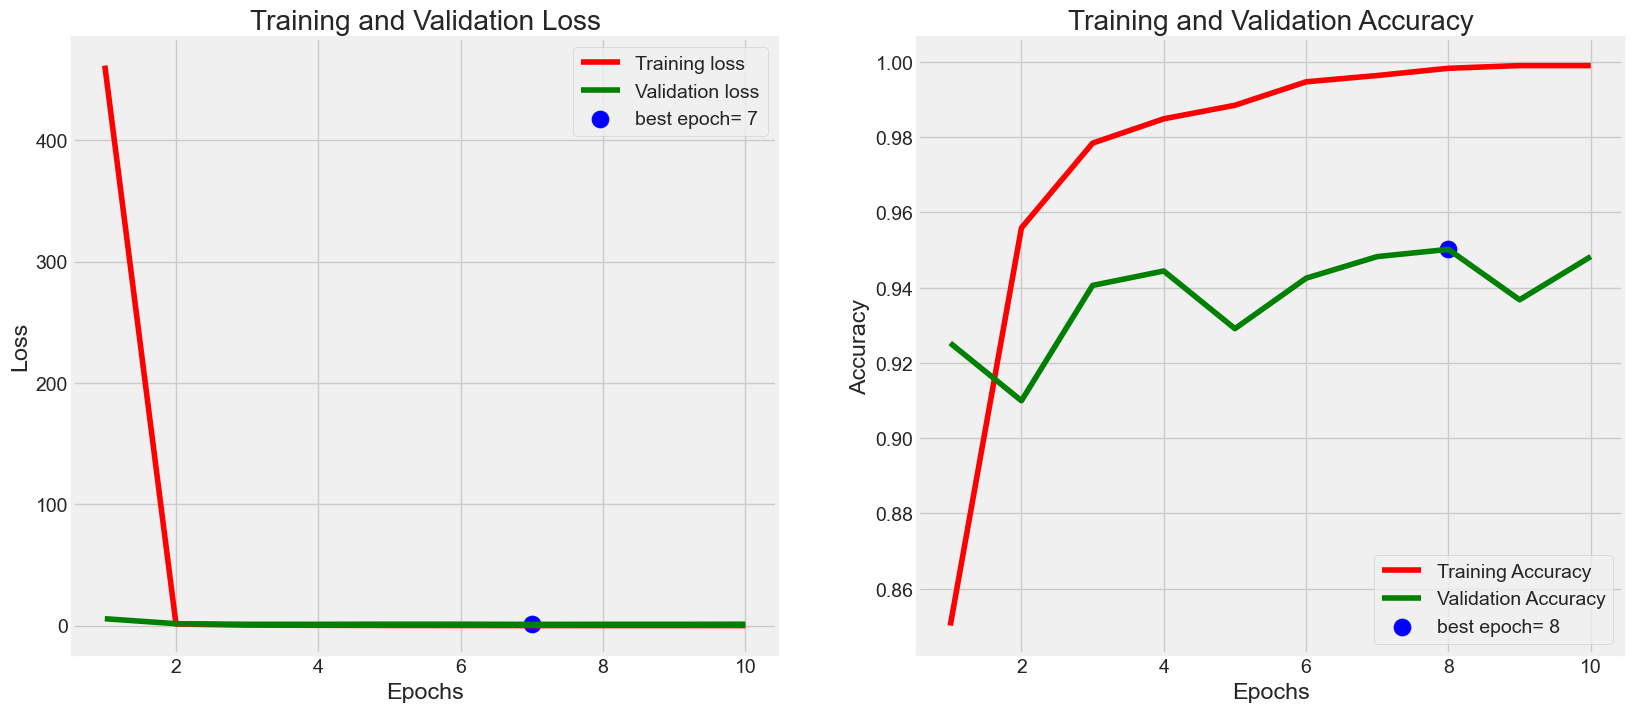

66/66 ━━━━━━━━━━━━━━━━━━━━ 294s 4s/step - accuracy: 0.9997 - loss: 0.0209
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.9509 - loss: 1.0026
9/9 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.9578 - loss: 0.4994
Train Loss:  0.018760526552796364
Train Accuracy:  0.9995205998420715
--------------------
Validation Loss:  1.129132866859436
Validation Accuracy:  0.9482758641242981
--------------------
Test Loss:  0.48633354902267456
Test Accuracy:  0.9636015295982361


In [19]:
import numpy as np
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       137
           1       0.98      0.97      0.98       385

    accuracy                           0.96       522
   macro avg       0.95      0.96      0.95       522
weighted avg       0.96      0.96      0.96       522



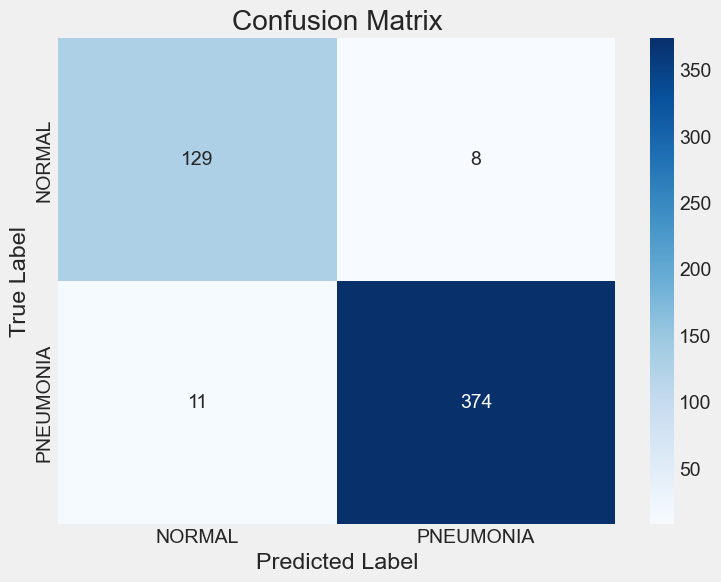

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on test data
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_gen.classes

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_gen.class_indices.keys(), 
            yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [23]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 224, 224,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 224, 224,  │          0 │ conv2d_14[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 224, 224,  │     36,928 │ activation_16[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 224, 224,  │          0 │ conv2d_15[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 224, 224,  │          0 │ activation_16[0]… │
│                     │ 64)               │            │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 224, 224,  │          0 │ add_4[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 224, 224,  │         65 │ activation_18[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 224, 224,  │          0 │ conv2d_16[0][0]   │
│ (Activation)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Multiply)          │ 3)                │            │ activation_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 224, 224,  │      3,584 │ multiply_4[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 112, 112,  │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 112, 112,  │    147,584 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 112, 112,  │          0 │ conv2d_18[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 112, 112,  │    147,584 │ activation_20[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 112, 112,  │          0 │ conv2d_19[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 112, 112,  │          0 │ activation_20[0]

 Total params: 617,601,230 (2.30 GB)

 Trainable params: 205,867,076 (785.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 411,734,154 (1.53 GB)

In [25]:
from tensorflow.keras.models import load_model
from PIL import Image

# Load the saved model
loaded_model = model

# Define class labels
class_labels = ["NORMAL", "PNEUMONIA"]

# Function to preprocess the input image
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = np.array(img)
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.repeat(img, 3, axis=-1)  # Repeat grayscale image to have 3 channels
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to make predictions
def predict_image(model, image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)
    return prediction

# Function to get predicted class and probability
def get_predicted_class(prediction):
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]
    probability = prediction[0][predicted_class_index]
    return predicted_class, probability

# Example usage
image_path = 'chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
prediction = predict_image(loaded_model, image_path)
predicted_class, probability = get_predicted_class(prediction)
print("Predicted Class:", predicted_class)
print("Probability:", probability)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
Predicted Class: NORMAL
Probability: 0.62439793


In [27]:
from keras.models import load_model 
model.save("network.h5") 
loaded_model = load_model("network.h5") 
#loss, accuracy = loaded_model.evaluate(test_data, test_targets) 


In [31]:
loaded_model = load_model("network.h5")


In [33]:
from tensorflow.keras.models import load_model
from PIL import Image


# Define class labels
class_labels = ["NORMAL", "PNEUMONIA"]

# Function to preprocess the input image
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = np.array(img)
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.repeat(img, 3, axis=-1)  # Repeat grayscale image to have 3 channels
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to make predictions
def predict_image(model, image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = loaded_model.predict(preprocessed_img)
    return prediction

# Function to get predicted class and probability
def get_predicted_class(prediction):
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]
    probability = prediction[0][predicted_class_index]
    return predicted_class, probability

# Example usage
image_path = 'chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
prediction = predict_image(loaded_model, image_path)
predicted_class, probability = get_predicted_class(prediction)
print("Predicted Class:", predicted_class)
print("Probability:", probability)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: NORMAL
Probability: 0.62439793
